# **import all the libs**

In [1]:
# get all the imports
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, BatchNormalization
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import PolynomialFeatures
from prepare_data_for_modal import prepare_data, series_to_supervised, split_sequence



Using TensorFlow backend.


# **get the train_x  train_y, test_x test_y, and define the model structure**

In [0]:
def model_base(stock_num):
    pre_stock_data, stock, news = prepare_data(stock_num)

    # Polymerise Stock data¶
    # since we are using only one data coloumn form stock
    # # to make polynomial feature set
    poly = PolynomialFeatures(degree=2)
    stock = poly.fit_transform(stock)

    # Split the data into train and test data¶
    train_x = np.hstack([stock[:400], news[:400]])
    # train_x = split_sequence(train_x, 7)
    # y就是要被预测的价格
    train_y = pre_stock_data.iloc[1:407, 9:].values
    train_y = series_to_supervised(train_y, 6, 1)

    test_x = np.hstack([stock[400:], news[400:]])
    # test_x = split_sequence(test_x, 7)

    test_y = pre_stock_data.iloc[400:, 9:].values

    # reshape the data acording to the lstm
    train_x = train_x.reshape(-1, 1, 7)
    test_x = test_x.reshape(-1, 1, 7)

    # Made on the basis of assumption made on data analysis
    # make model
    model = Sequential()
    # layer 1
    model.add(LSTM(128, input_shape=(1, train_x.shape[2:][0]), activation='relu', return_sequences=True))
    model.add(Dropout(0.2))  # 全连接相关，尝试丢掉一些输出
    model.add(BatchNormalization())
    # layer 2
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # layer 3
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # layer 4
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    # layer 5
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # layer 6
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # final output in 1
    model.add(Dense(7))

    # make optimiser
    opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, decay=0.0)
    # compile the model
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

    # to log the data for tensorboard
    time = datetime.now()
    tbCallBack = keras.callbacks.TensorBoard(log_dir='./log/stock_'+stock_num+'_baseline' + str(time), write_graph=True)

    # for the model checkpoints
    filepath = './log/stock'+stock_num+'_baseline_weights.best.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, tbCallBack]
    model.summary()
    return model, callbacks_list, train_x, train_y, pre_stock_data, test_x, test_y


# **train the model and show the results**

/content/prepare_data_for_modal.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_stock1_data['Month'][i] = int(pre_stock1_data['Date'][i].split('/')[1])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 1, 128)            69632     
_________________________________________________________________
dropout_49 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_26 (LSTM)               (None, 1, 128)            131584    
_________________________________________________________________
dropout_50 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 1, 128)            512       
_________________________________________________________________
lstm_27 (LSTM)               (None, 128)              

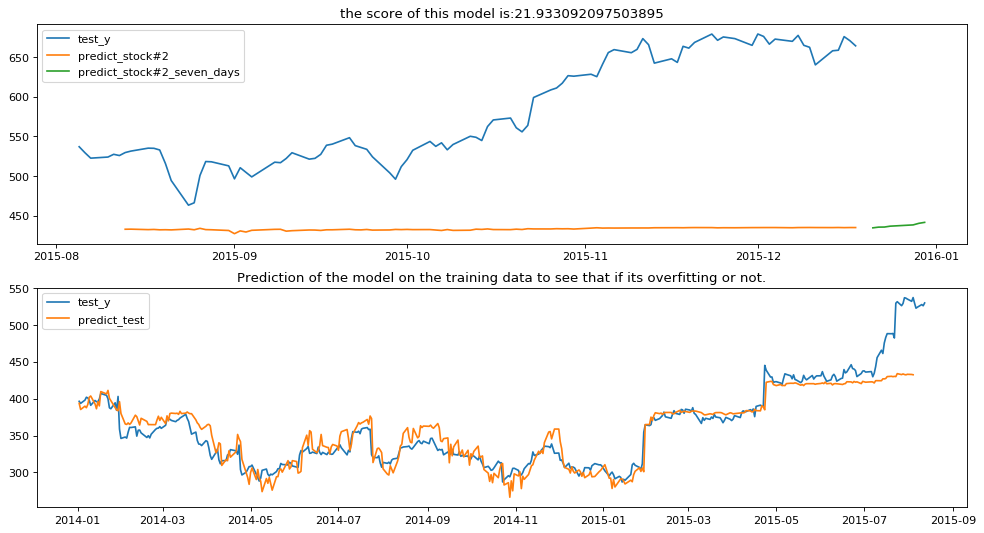

In [11]:
def Framed_training(stock_num):
    model, callbacks_list, train_x, train_y, pre_stock_data,test_x, test_y = model_base(stock_num)
    l = len(train_x)
    frame = int(l * 0.60)
    shift = int(l * .20)
    start = 0
    brake = False
    end_frame = False
    step = 0
    while brake == False:
        if start + frame < l:
            step += 1
            print(step, '  :::::::::::::::::::::::::::::::::::::::::::::')
            X = train_x[start:start + frame]
            Y = train_y[start:start + frame]
            model.fit(
                X
                , Y
                , epochs=100
                , batch_size=10
                , verbose=1
                , validation_split=0.1
                , callbacks=callbacks_list
            )
            start = start + shift
        else:
            if end_frame == True:
                step += 1
                print(step, start, 'end train  :::::::::::::::::::::::::::::::::::::::::::::')
                X = train_x[start:]
                Y = train_y[start:]
                if len(X) > 0:
                    model.fit(
                        X
                        , Y
                        , epochs=100
                        , batch_size=10
                        , verbose=1
                        , validation_split=0.1
                        , callbacks=callbacks_list
                    )
                brake = True
            else:
                step += 1
                print(step, start, 'end frame  :::::::::::::::::::::::::::::::::::::::::::::')
                X = train_x[start:]
                Y = train_y[start:]
                if len(X) > 0:
                    model.fit(
                        X
                        , Y
                        , epochs=150
                        , batch_size=10
                        , verbose=1
                        , validation_split=0.1
                        , callbacks=callbacks_list
                    )
                start = start + shift
                end_frame = True

    predict = model.predict(test_x)
    # Plot the data that is predicted by modelc
    # matplotlib inline
    fig = plt.figure(figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')
    # index = pd.date_range(start = pre_stock_data['Date'][0], end = pre_stock_data['Date'][406], freq = "D")
    predict_Date = ['2015/12/21', '2015/12/22', '2015/12/23', '2015/12/24', '2015/12/28', '2015/12/29', '2015/12/30']
    dataArr = np.append(pre_stock_data['Date'], predict_Date)
    index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in dataArr]
    predata = np.squeeze(predict[:, :1], axis=1)[0:-6]
    day1 = np.squeeze(predict[:, :1], axis=1)[-1]
    day2 = np.squeeze(predict[:, 1:2], axis=1)[-1]
    day3 = np.squeeze(predict[:1, 2:3], axis=1)[-1]
    day4 = np.squeeze(predict[:1, 3:4], axis=1)[-1]
    day5 = np.squeeze(predict[:1, 4:5], axis=1)[-1]
    day6 = np.squeeze(predict[:1, 5:6], axis=1)[-1]
    day7 = np.squeeze(predict[:1, 6:7], axis=1)[-1]
    predict_arr = np.round(np.array([day1, day2, day3, day4, day5, day6, day7]), 1)
    print('predict_seven_days == ', predict_arr)
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    ax1.plot(index[400:496], np.squeeze(test_y, axis=1), label='test_y')
    ax1.plot(index[406:496], np.squeeze(predata), label='predict_stock#' + stock_num)
    ax1.plot(index[496:503], np.squeeze(predict_arr), label='predict_stock#' + stock_num + '_seven_days')
    score = (abs(np.squeeze(test_y, axis=1) - np.squeeze(predict[:, 6:7], axis=1)) / np.squeeze(test_y, axis=1)).sum()
    ax1.set_title('the score of this model is:' + str(score))
    train_y_show = pre_stock_data.iloc[1:407, 9:].values
    ax2.set_title('Prediction of the model on the training data to see that if its overfitting or not.')
    ax2.plot(index[:406], np.round(np.squeeze(train_y_show, axis=1), 1), label='test_y')
    ax2.plot(index[:400], np.round(np.squeeze(model.predict(train_x)[:, :1], axis=1), 1), label='predict_test')
    ax1.legend()
    ax2.legend()
    plt.show()

Framed_training('2')